# Базовые тесты

In [45]:
import TechCore.Simulator.simulator_optimized as simulator
import TechCore.Strategies.Stoikov as Stoikov
import TechCore.Simulator.get_info as get_info
import TechCore.Simulator.load_data as load_data

from importlib import reload

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '../TechCore/data/md/btcusdt_Binance_LinearPerpetual/'
T = pd.Timedelta(10, 'm').delta

In [46]:
reload(simulator)
reload(Stoikov)
reload(get_info)
reload(load_data)

<module 'TechCore.Simulator.load_data' from 'C:\\Users\\artem\\.Computer Science\\CMF\\Projects\\High_Frequency_Market_Making\\TechCore\\Simulator\\load_data.py'>

In [47]:
md = load_data.load_md_from_file(path=PATH_TO_FILE, t=T)

In [48]:
latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta

sim = simulator.SimOptim(md, latency, md_latency)

In [49]:
#delay between orders
T = pd.Timedelta(0.1, 's').delta

strategy = Stoikov.Strategy(
    t=T,
    risk_koef=0.1,
    time_vol=60*10**9,
    time_oi=60*10**9,
    avg_sum_oi=800,
    avg_time_oi=57471412238,
    order_fees=0.00001,
    avg_volatility=300,
    min_asset_value=0.001
)
# вся эта история с avg нужна для того, чтобы order_intensity и volatility были равны 1 в среднем.

In [50]:
trades_list, md_list, updates_list, all_orders = strategy.run(sim)

In [51]:
df = get_info.get_pnl(updates_list)

In [52]:
dt = pd.to_datetime(df.receive_ts)

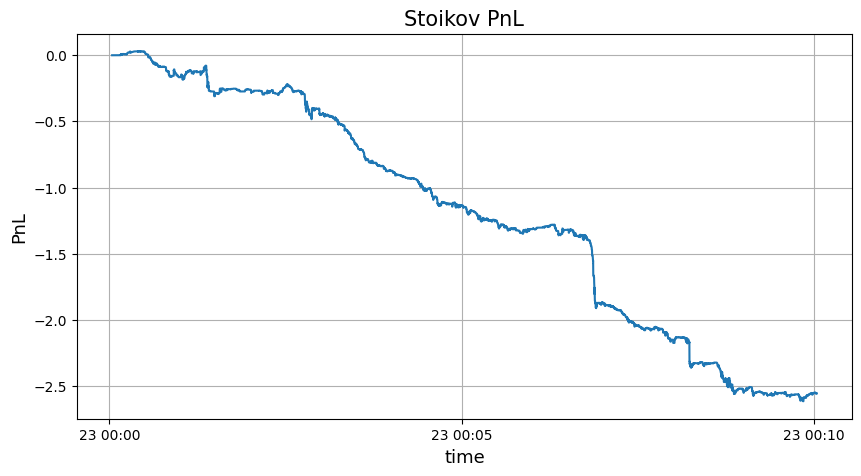

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Stoikov PnL", fontsize=15)
plt.grid()
plt.show()

In [54]:
strategy.get_logs().keys() # свой pnl

dict_keys(['asset_position', 'usd_position', 'best_ask', 'best_bid', 'ask_place', 'bid_place', 'ask_diff', 'bid_diff', 'my_spread', 'stock_spread', 'total_liq', 'pnl', 'pnl_with_liq', 'order_intensity', 'volatility', 'midprice', 'indiff_price', 'own_trade_time', 'place_order_time', 'vol_window_size', 'oi_window_size', 'vol_window_len'])

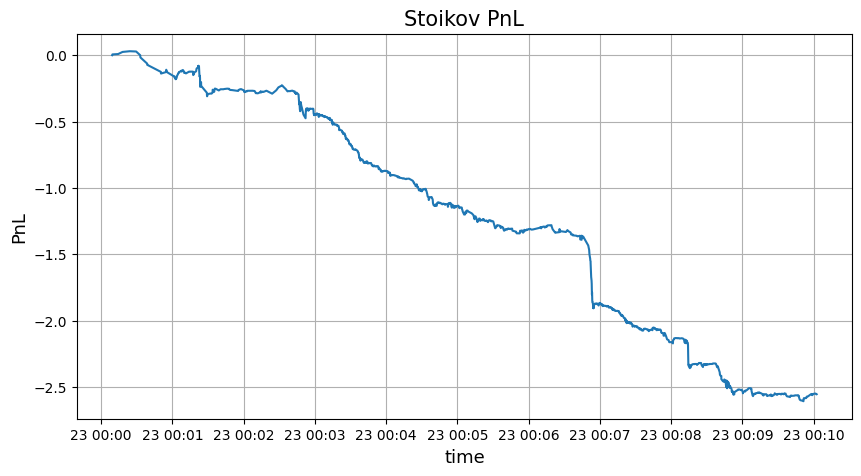

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(strategy.get_logs()['own_trade_time']), strategy.get_logs()['pnl_with_liq'], '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("Stoikov PnL", fontsize=15)
plt.grid()
plt.show()

In [56]:
logs = strategy.get_logs()

In [57]:
for i in logs.keys():
    if len(logs[i]) == 5367:
        print(i)

In [58]:
own_trade_group = [
    'asset_position',
    'usd_position',
    'total_liq',
    'pnl',
    'pnl_with_liq',
]
own_trade_time = 'own_trade_time'

In [59]:
place_order_group = [
    'best_ask',
    'best_bid',
    'ask_place',
    'bid_place',
    'my_spread',
    'stock_spread',
    'order_intensity',
    'volatility',
    'midprice',
    'indiff_price'
]

place_order_time = 'place_order_time'

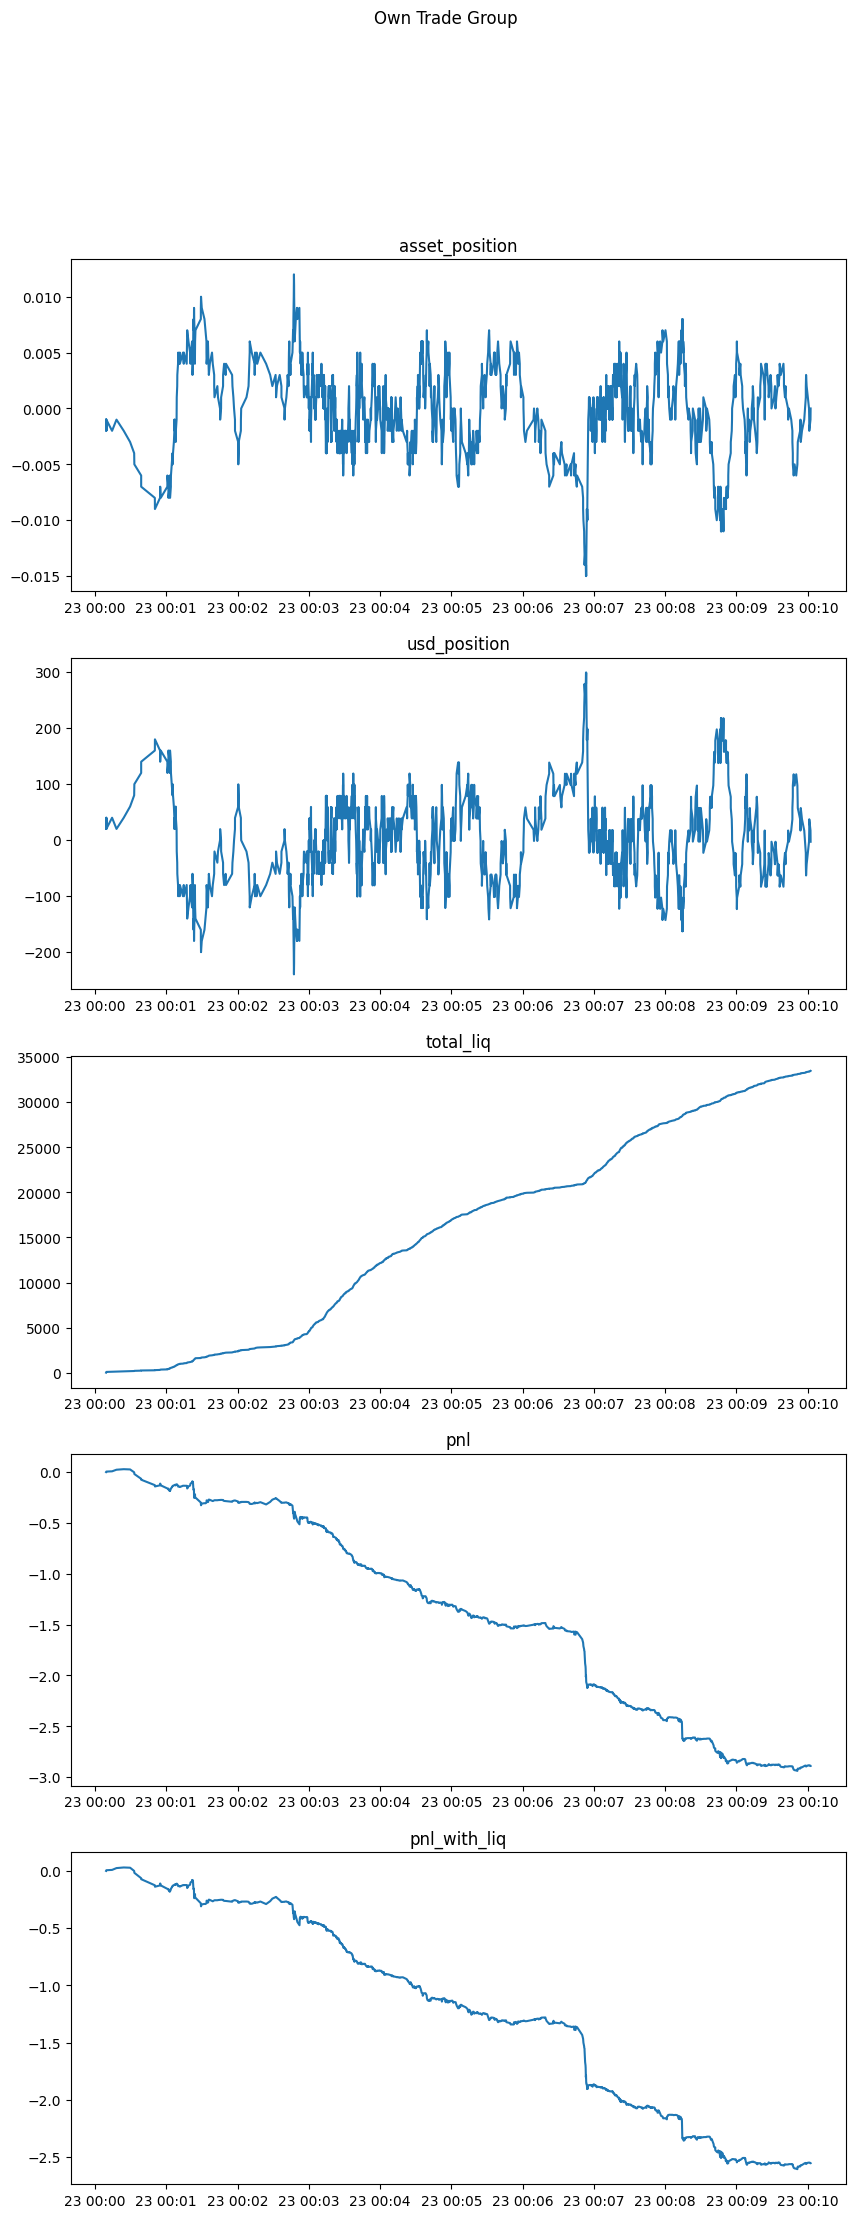

In [60]:
fig, axs = plt.subplots(len(own_trade_group), figsize=(10, 5*len(own_trade_group)))
fig.suptitle('Own Trade Group')

ind = 0
for i in own_trade_group:
    axs[ind].plot(pd.to_datetime(logs[own_trade_time]), logs[i])
    axs[ind].set_title(i)
    ind += 1

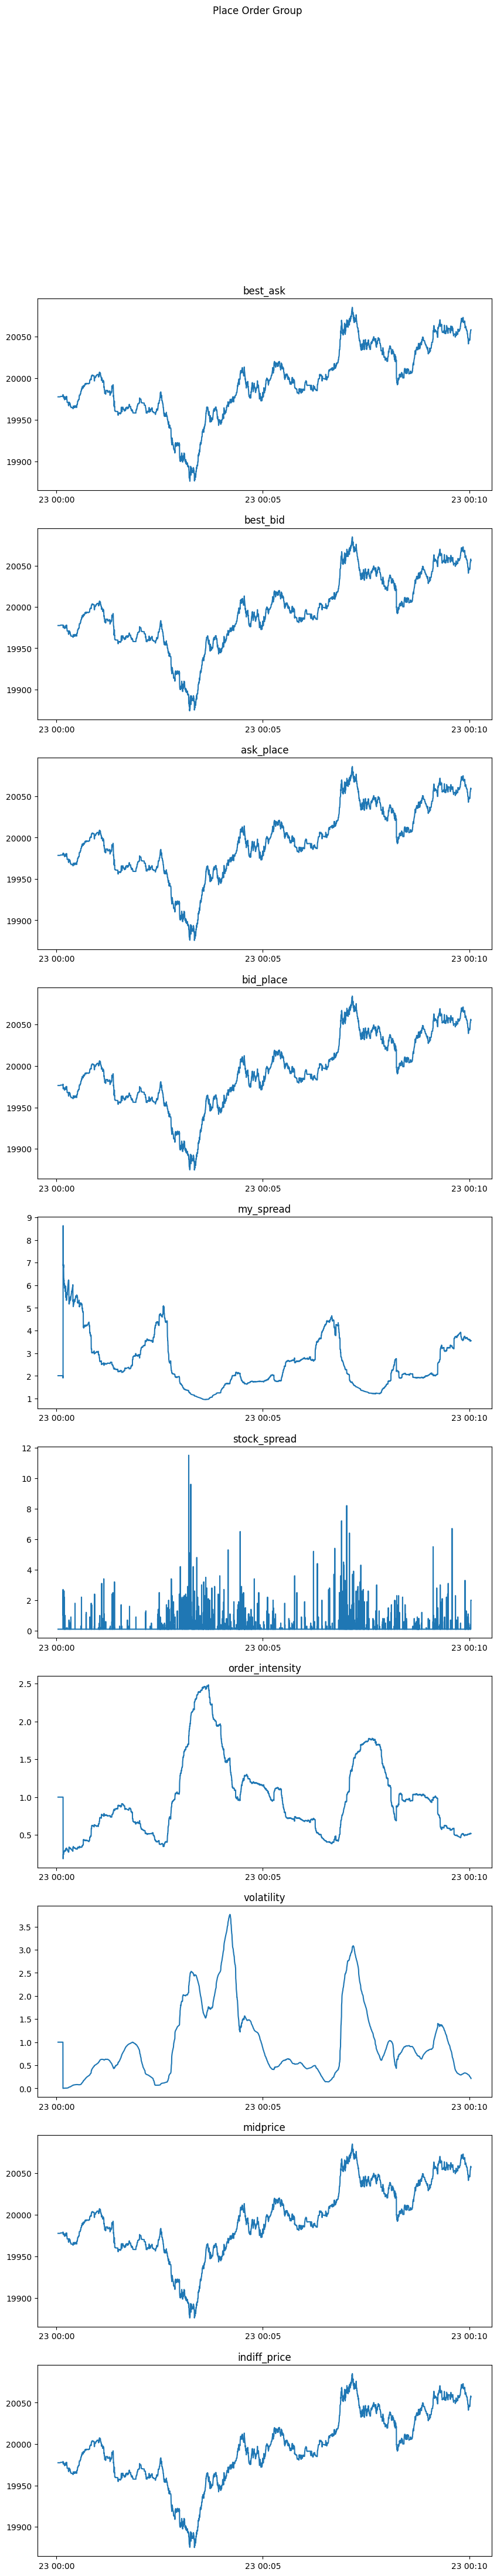

In [61]:
fig, axs = plt.subplots(len(place_order_group), figsize=(10, 5*len(place_order_group)))
fig.suptitle('Place Order Group')

ind = 0
for i in place_order_group:
    axs[ind].plot(pd.to_datetime(logs[place_order_time]), logs[i])
    axs[ind].set_title(i)
    ind += 1

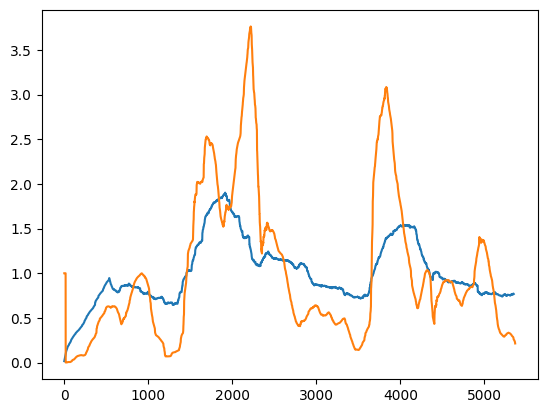

In [62]:
plt.plot(logs['vol_window_len'] / np.array(logs['vol_window_len']).mean())
plt.plot(logs['volatility'])

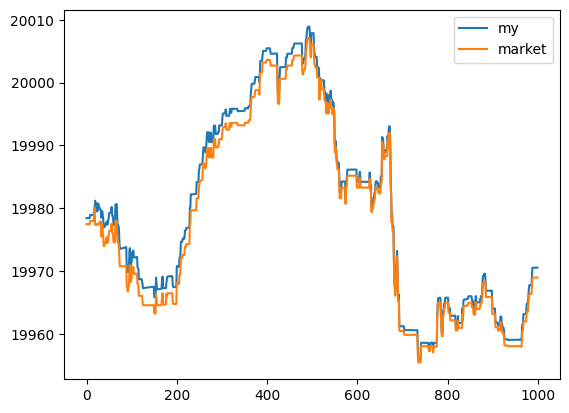

In [63]:
k=1000
plt.plot(logs['ask_place'][0:k], label='my')
plt.plot(logs['best_ask'][0:k], label='market')
plt.legend()

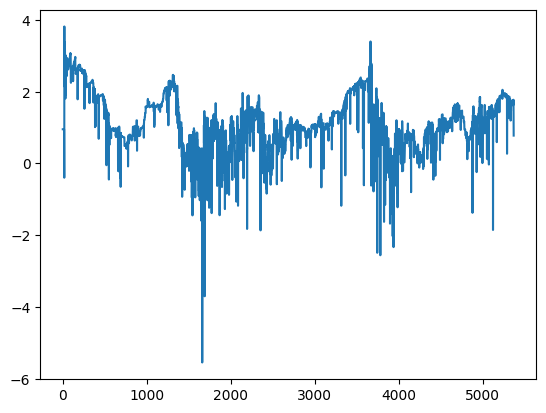

In [64]:
plt.plot(np.array(logs['ask_place']) - np.array(logs['best_ask']))

# Подбор risk_koef (gamma)

In [65]:
def run_stoikov(gamma):
    reload(simulator)
    reload(Stoikov)
    reload(get_info)
    reload(load_data)
    T = pd.Timedelta(10, 'm').delta
    md = load_data.load_md_from_file(path=PATH_TO_FILE, t=T)
    latency = pd.Timedelta(10, 'ms').delta
    md_latency = pd.Timedelta(10, 'ms').delta

    sim = simulator.SimOptim(md, latency, md_latency)

    T = pd.Timedelta(0.1, 's').delta
    strat = Stoikov.Strategy(
        t=T,
        risk_koef=gamma,
        time_vol=60 * 10 ** 9,
        time_oi=60 * 10 ** 9,
        avg_sum_oi=800,
        avg_time_oi=57471412238,
        order_fees=0.00001,
        avg_volatility=300,
        min_asset_value=0.001
    )
    trades_list, md_list, updates_list, all_orders = strat.run(sim)
    return strat.get_logs()

In [66]:
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1]
logs_list = []
for gamma in gamma_list:
    logs_list.append(run_stoikov(gamma))

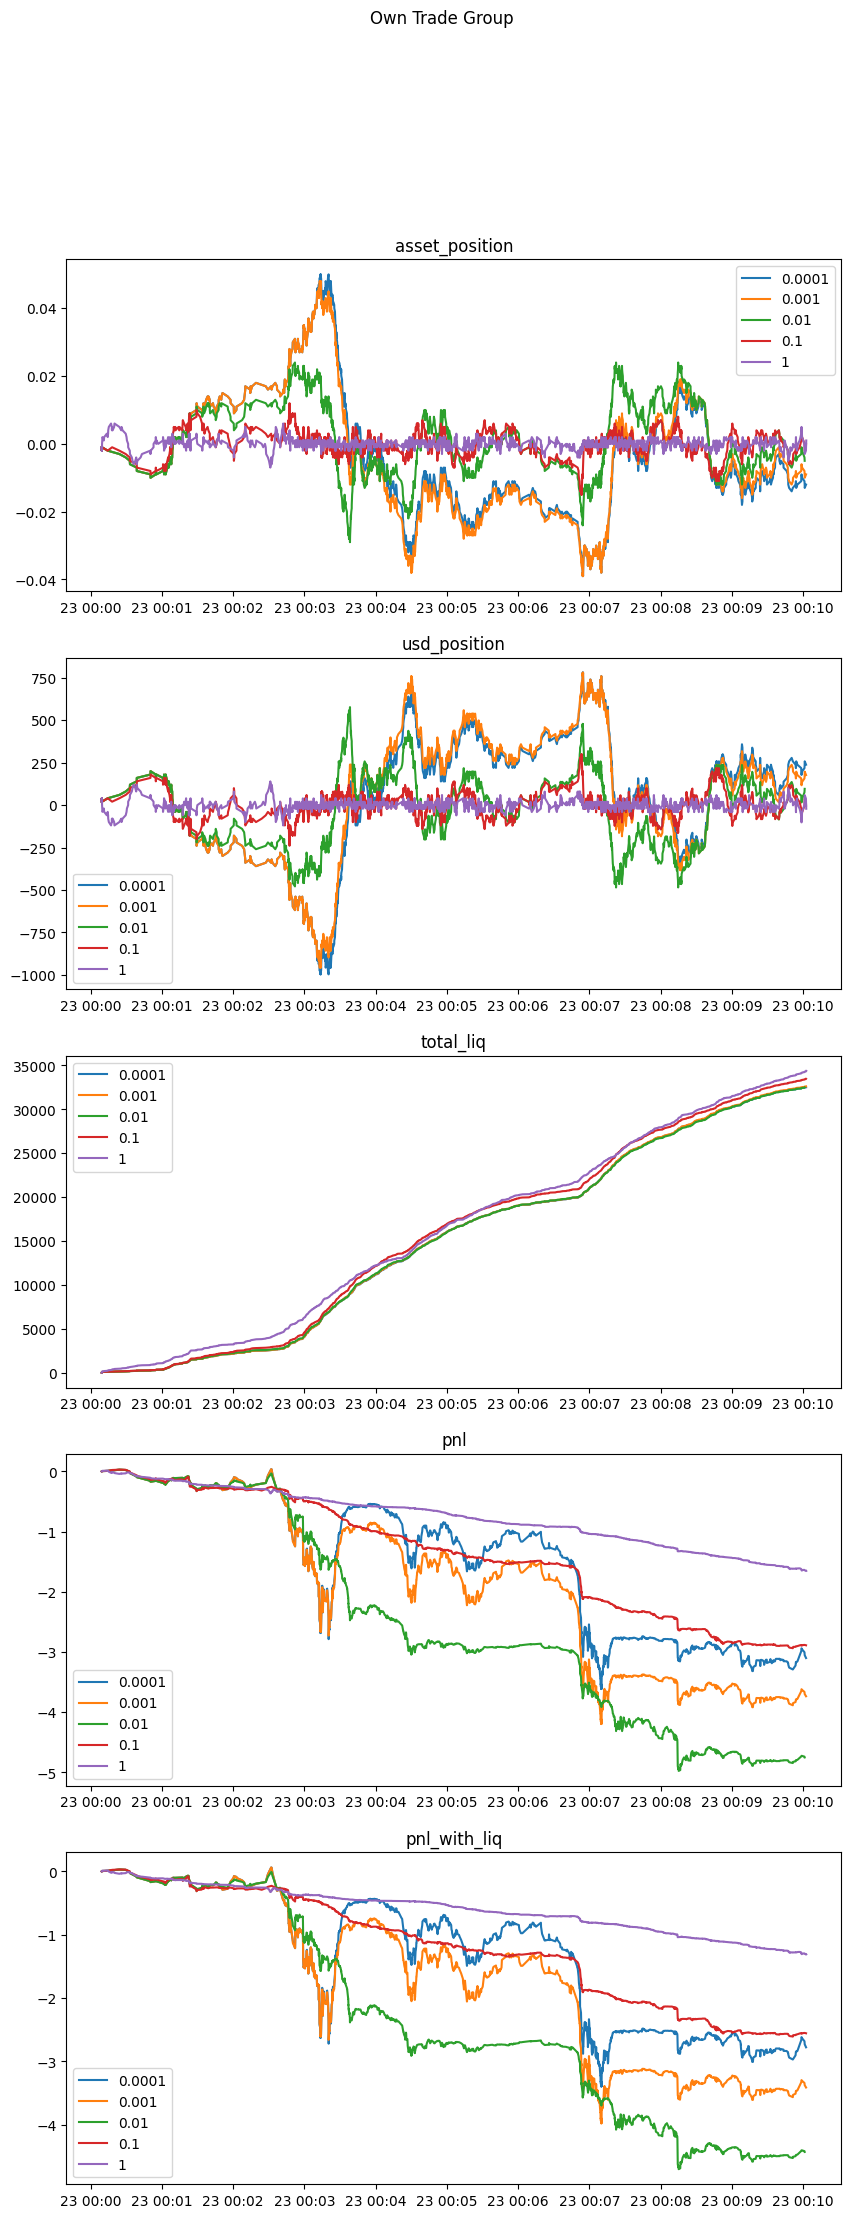

In [67]:
fig, axs = plt.subplots(len(own_trade_group), figsize=(10, 5*len(own_trade_group)))
fig.suptitle('Own Trade Group')

ind = 0
for i in own_trade_group:
    for gamma, logs in zip(gamma_list, logs_list):
        axs[ind].plot(pd.to_datetime(logs[own_trade_time]), logs[i], label=gamma)
    axs[ind].set_title(i)
    axs[ind].legend()
    ind += 1

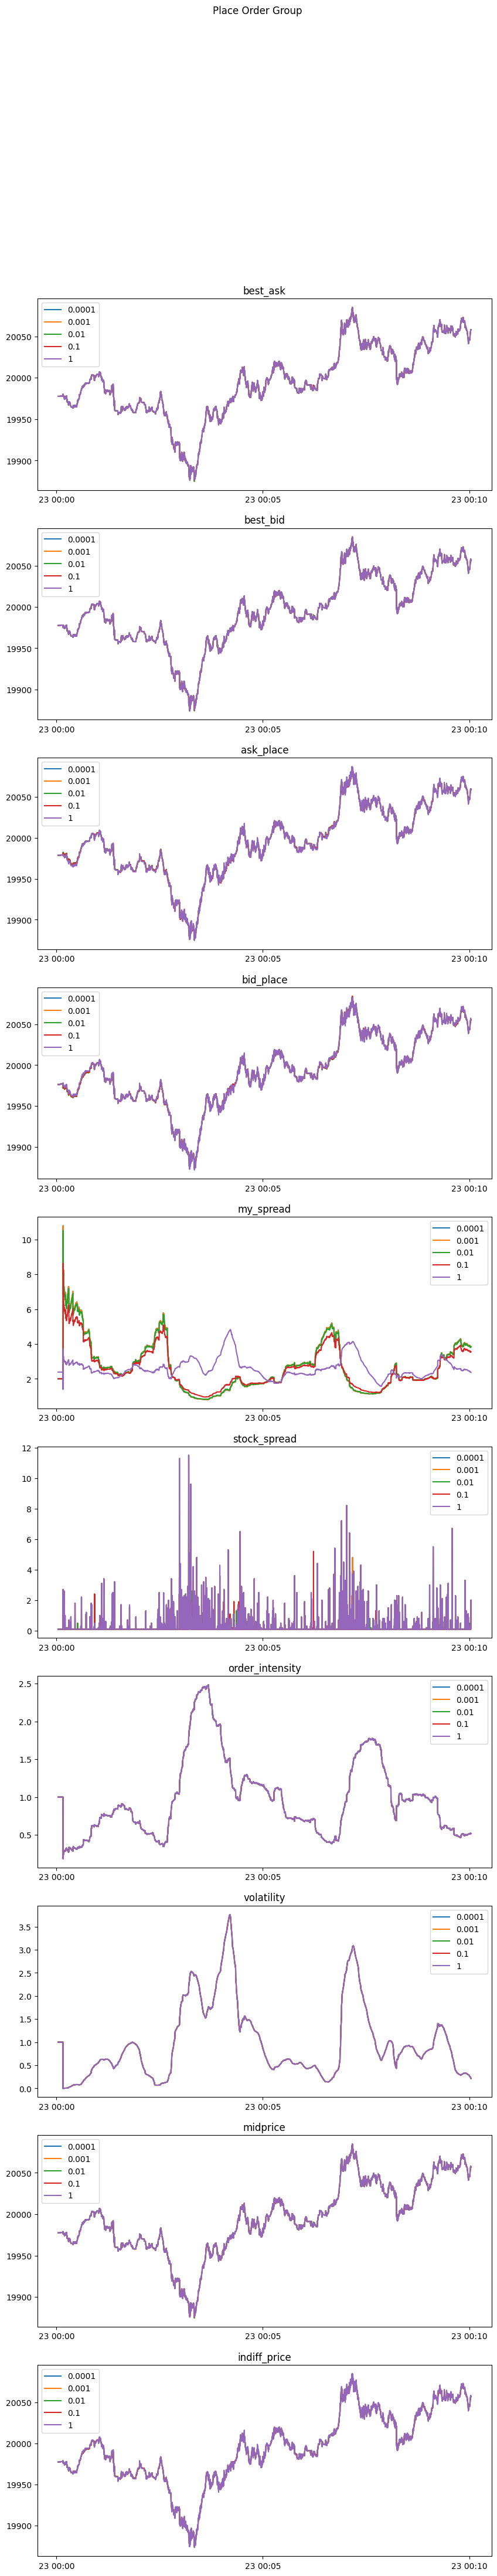

In [68]:
fig, axs = plt.subplots(len(place_order_group), figsize=(10, 5*len(place_order_group)))
fig.suptitle('Place Order Group')

ind = 0
for i in place_order_group:
    for gamma, logs in zip(gamma_list, logs_list):
        axs[ind].plot(pd.to_datetime(logs[place_order_time]), logs[i], label=gamma)
    axs[ind].set_title(i)
    axs[ind].legend()
    ind += 1

В целом - все гипотезы (про gamma) подтвердились. Мне кажется что это если не идеально, то около того :)